In [1]:
import numpy  as np

# Masking


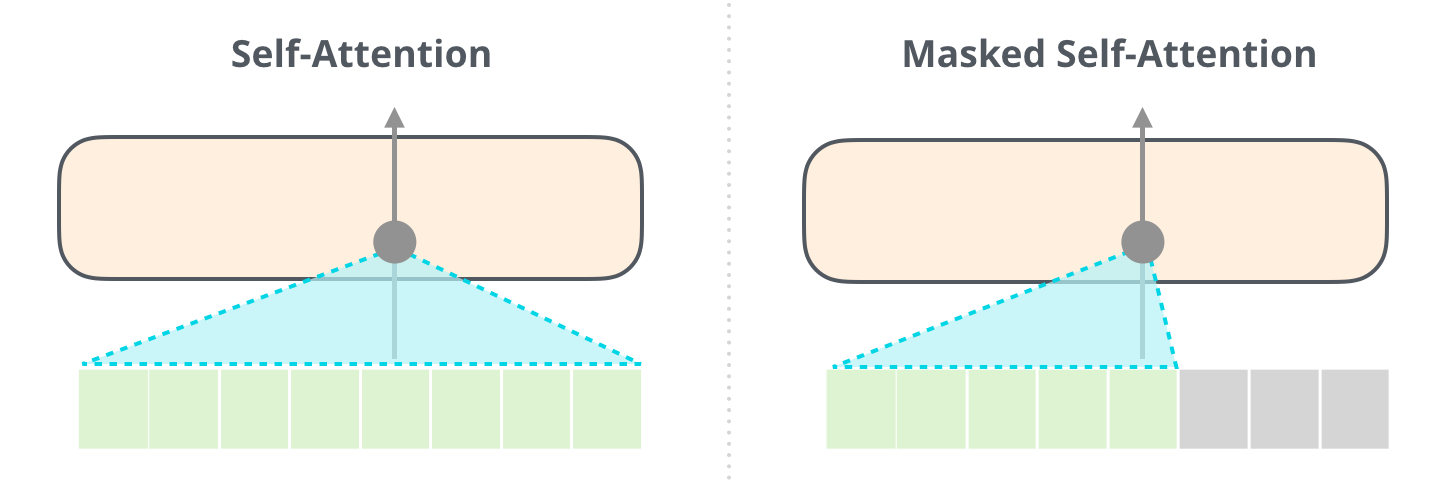


So let's talk about the difference between attention and mask attention

lets take a sample score value for  5 words

In [2]:
scores=np.random.randint(1,5,(5,5))
print(scores)

[[1 4 2 4 2]
 [3 2 4 1 4]
 [2 3 3 3 2]
 [3 3 4 1 4]
 [1 2 3 3 1]]


so this is the score we have for each word with respect to each word

## Why Masking is needed 

### From Research paper


#### We also modify the self-attention
#### sub-layer in the decoder stack to prevent positions from attending to subsequent positions. This
#### masking, combined with fact that the output embeddings are offset by one position, ensures that the
#### predictions for position i can depend only on the known outputs at positions less than i.


So we are going to build the Masking layer and the attention Layer in Decoder is slightly different from encoder attention Layer  

“I am a ______ boy and I will help others.”  and “I am a ______ boy and I will not help others.” we would intuitively fill good/bad depending on ( as that is the most probable one). So while encoding a word, it needs to know everything that comes in the whole sentence (before to it and after to it )

Which is why in the Encoder, the query was performed with all words against all words


But in the case of Decoder it is auto-regressive(autoregressive process is one in which the current value is based on the  preceding values)  if its "good" you should write "help others" , else if " bad " write "not help" 
So "help" can access to "good" and it pays attention to it ,but decoders are auto regressive "good " cannot pay attention to "help" because good is already written so it can pay attention to its prior words but paying attention to future words in auto-regressive Model is less-meaningul so we are ensuring that the """ predictions for position i can depend only on the known outputs at positions less than i """

For Eg let's say you are writing a Story (no mistakes while writing) you will write the the words thinking about the words you have written (Decoders previous output's) and the context of the story (Encoder output) and you are not going to think about the words you will write in the future(Decoders future word's)  
Even after you have written a story if you look at a particular position (Say line 20 word 6) you will think of the words written prior to it to ensure the cuurent word.So the context of the words would not depend on future words but future words may have attention to it so that's why we are Masking the future words 

> combined with fact that the output embeddings are offset by one position, ensures that the  predictions for position i can depend only on the known outputs at positions less than i.


## How Masking is Done

### From Research paper

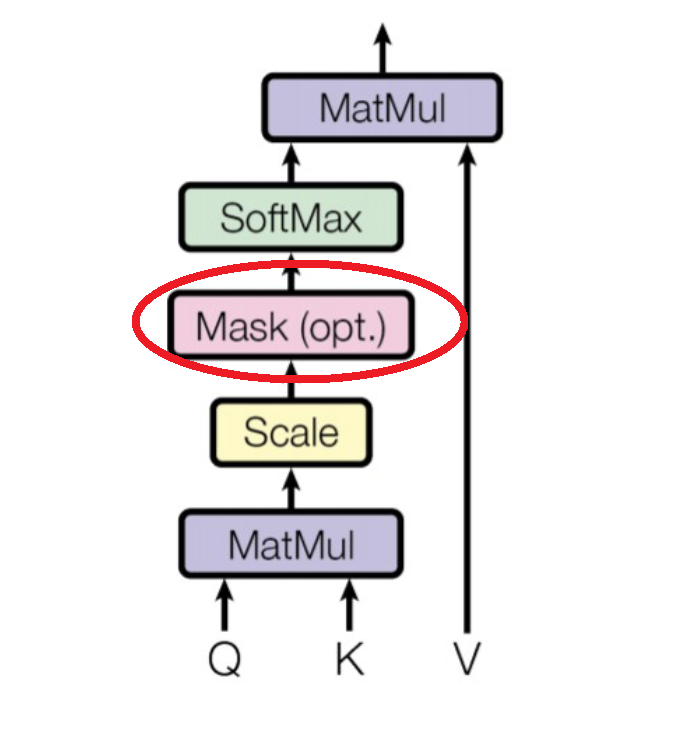

#### Similarly, self-attention layers in the decoder allow each position in the decoder to attend to
#### all positions in the decoder up to and including that position. We need to prevent leftward
#### information flow in the decoder to preserve the auto-regressive property. We implement this
#### inside of scaled dot-product attention by masking out (setting to −∞) all values in the input
#### of the softmax which correspond to illegal connections. See Figure 2.


So we are going to set the future position to  -inf so it becomes zero after softmax and the words will not pay Attention to the future words 
Let's do it !!



1) create look ahead Mask

this is how look ahead mask looks like
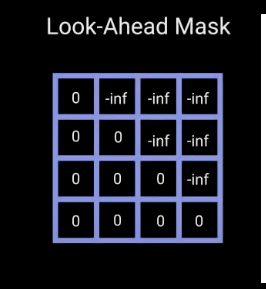

In [3]:
look_ahead_mask=np.tril((np.ones(scores.shape)))
look_ahead_mask=np.where(look_ahead_mask==1,0,-1000000000)
# " attend to  all positions in the decoder up to and including that position " so that we are including the x[i][i] position

print(look_ahead_mask)

[[          0 -1000000000 -1000000000 -1000000000 -1000000000]
 [          0           0 -1000000000 -1000000000 -1000000000]
 [          0           0           0 -1000000000 -1000000000]
 [          0           0           0           0 -1000000000]
 [          0           0           0           0           0]]


2) Add Mask with the matrix and apply softmax

In [4]:
z=look_ahead_mask+scores
print(z)

[[         1 -999999996 -999999998 -999999996 -999999998]
 [         3          2 -999999996 -999999999 -999999996]
 [         2          3          3 -999999997 -999999998]
 [         3          3          4          1 -999999996]
 [         1          2          3          3          1]]


Let's make it a function 

In [5]:
class Softmax():
    def __init__(self,axis=-1):
        self.axis=axis
    def __call__(self,x):
        e_x = np.exp(x - np.max(x,axis=self.axis,keepdims=True)) # max(x) subtracted for numerical stability
        self.sm = e_x / np.sum(e_x,axis=self.axis,keepdims=True)
        return self.sm
        
    def backward(self,err):
               
        SM = self.sm.reshape(-1,1)
        jac = np.diagflat(self.sm) - np.dot(SM, SM.T)
        jac=np.sum(jac,axis=1,keepdims=True).reshape(err.shape)
        
        return jac*err
 

In [10]:
def Masking(matrix):
    
    look_ahead_mask=np.tril((np.ones(matrix.shape)))
    look_ahead_mask=np.where(look_ahead_mask==1,0,-1e20)
    scores=matrix +look_ahead_mask
   
    return scores

mat=np.random.randint(1,8,(5,5))
scores=Masking(mat)
print("scores after masking\n")
print(scores,'\n\n\n')
Soft=Softmax()
print("scores after softmax\n")

print(Soft(scores),'\n\n\n')

print("scores while backpropagating \n softmax layer will not  allow to flow the gradients through masked scores\n")

err=np.ones((scores.shape))
print(Soft.backward(err))


    

scores after masking

[[ 7.e+00 -1.e+20 -1.e+20 -1.e+20 -1.e+20]
 [ 3.e+00  2.e+00 -1.e+20 -1.e+20 -1.e+20]
 [ 7.e+00  1.e+00  1.e+00 -1.e+20 -1.e+20]
 [ 6.e+00  6.e+00  1.e+00  1.e+00 -1.e+20]
 [ 5.e+00  3.e+00  6.e+00  5.e+00  1.e+00]] 



scores after softmax

[[1.         0.         0.         0.         0.        ]
 [0.73105858 0.26894142 0.         0.         0.        ]
 [0.99506695 0.00246652 0.00246652 0.         0.        ]
 [0.49665357 0.49665357 0.00334643 0.00334643 0.        ]
 [0.20525735 0.02777856 0.55794732 0.20525735 0.00375942]] 



scores while backpropagating 
 softmax layer will not  allow to flow the gradients through masked scores

[[-4.          0.          0.          0.          0.        ]
 [-2.92423431 -1.07576569  0.          0.          0.        ]
 [-3.98026781 -0.0098661  -0.0098661   0.          0.        ]
 [-1.9866143  -1.9866143  -0.0133857  -0.0133857   0.        ]
 [-0.8210294  -0.11111425 -2.23178929 -0.8210294  -0.01503768]]


So we got scores for each word with respect to its prior words in the sentence

### Implementing masking with Attention Network

In [ ]:
class SelfAttn():
    def __init__(self,dim,heads):
        
        self._Keyss=Linear(dim,dim*heads) # for self attention Feed_Forward(dim,dim) it has only one vector to store the attention between two words where multi head attention has muliple vectors to store relationship/attention between two words for improved performance
        self._Query=Linear(dim,dim*heads)
        self._Value=Linear(dim,dim*heads)
        self._Unify=Linear(dim*heads,dim)
        self.head=heads
        self.D=dim
        self.sm=Softmax()
        self.param={}
        
    def forward(self,input_vec,mask=None):# after embedding layer and adding with pos enc the input reaches attention layer
        
        #initially we are passing the input vectors through (key,query ,value) Weights
        queries=self._Query.forward(input_vec) #determines which values to focus
        keys   =self._Keyss.forward(input_vec) #hint to find score for its value pair      
        values =self._Value.forward(input_vec) # extract interesting features  
        #print(self._Keyss.Weight,'\n\n',self._Query.Weight,'\n\n')
        
        
        # batchsize,seqlen,head*dim   ====>>>   batchsize*head,seqlen,dim since the dimensions of sequence will react with other all sequences within same head ,heads wont react with each other
        sha=list(keys.shape)
        self.sha_=sha.copy()     
        sha[-1]=int(sha[-1]/self.head)
        sha[0]*=self.head
        self.sha=sha
        
        
        # Weight are reshaped

        keys=keys.reshape(sha)
        queries=queries.reshape(sha)
        values=values.reshape(sha)
        
        # parameters are saved for backpropagation
        
        self.param['k']=keys   
        self.param['q']=queries
        self.param['v']=values
        
        
        # Each Query is iterated with each other key to Get its score with the corresponding word
        
        #print(keys,'\n\n',queries,'\n\n')       
        W_=np.matmul(queries, np.transpose(keys, (0, 2, 1)))#/(self.D**0.5)
        
        if(mask):
            W_=Masking(W_)# masking will be done each word will not have acces to future word
            
        
        print('\n\n',queries,'\n\n',keys,'\n\n',W_,'\n\n')
        W=self.sm(W_) 

        self.W=W
        
        Y=np.matmul(W,values) # the scores are multiplied with the values and they are added
        # concat the heads
        Y=Y.reshape(self.sha_)
        op=self._Unify.forward(Y)
        
        return op
    
    def backward(self,err,lr):
        
        dY=self._Unify.backward(err,lr)
        dY=dY.reshape(self.sha)
        
        dval=np.matmul(self.W,dY)
        
        
        dW =np.matmul(self.param['v'],np.transpose(dY, (0, 2, 1)))
        
        dW_=self.sm.backward(dW)
        dkeys=np.matmul(dW_,self.param['q'])/(self.D**0.5)
        dque=np.matmul(dW_,self.param['v'])/(self.D**0.5)
        
        dkeys=dkeys.reshape(self.sha_)
        dque=dque.reshape(self.sha_)
        dval=dval.reshape(self.sha_)
        
        der_inp =self._Keyss.backward(dkeys,lr)
        der_inp+=self._Query.backward(dque,lr)
        der_inp+=self._Value.backward(dval,lr)
        
        return der_inp       
        
        
    
        
    

# DropOut

DropOut is a regularization technique for reducing overfitting in artificial neural networks by preventing complex co-adaptations on training data

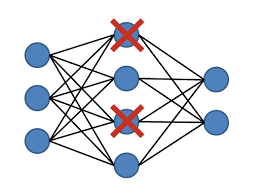

Deactivate some neurons so that t could learn to predict if even all feaures are not given

In [63]:
class Dropout():
    def __init__(self,drop_probability):
        self.drop_probability=drop_probability
    def forward(self,X):
            keep_probability = 1 - self.drop_probability
            self.mask = np.random.uniform(0, 1.0, X.shape) < keep_probability   
            print(self.mask)
            return self.mask * X 
    def backward(self,err):
            return self.mask*err

In [64]:
x=np.random.randint(0, 10, (4,5))
print(x)
z=Dropout(0.5)
print(z.forward(x))
print(z.backward(x))

[[8 8 1 1 3]
 [5 1 6 3 3]
 [8 9 4 8 3]
 [5 6 5 3 5]]
[[False  True False  True  True]
 [ True False  True  True  True]
 [False  True False False  True]
 [False False False  True  True]]
[[0 8 0 1 3]
 [5 0 6 3 3]
 [0 9 0 0 3]
 [0 0 0 3 5]]
[[0 8 0 1 3]
 [5 0 6 3 3]
 [0 9 0 0 3]
 [0 0 0 3 5]]



# Feedforward

Feedforward layer of the neural network   
consists of two linear transformations with a ReLU activation in between

In [65]:
class Relu():
    def forward(self,X):
        self.x=X
        X[X<0]=0
        return X
    def backward(self,err):
        err[self.x<=0]=0
        return err
        

In [66]:
class Linear():
    def __init__(self,input_dim,output_dim):
        self.Weight=np.random.randint(0,2,size=(input_dim,output_dim)).astype('float32')#*np.sqrt(6./input_dim+output_dim)#Xavier Initializatio

        #self.Weight=np.random.uniform(-1,1,size=(input_dim,output_dim))*np.sqrt(6./input_dim+output_dim)#Xavier Initializatio
    def forward(self,data):# data shape is batchsize,....,hidden layer
        self.input=data
        output=np.dot(data,self.Weight)
        return output
    def backward(self,err,lr):
        der_W=np.dot((self.input).reshape(-1,self.input.shape[-1]).T,err.reshape(-1,err.shape[-1])).astype('float32') 
        der_inp=np.dot(err,self.Weight.T)
        self.Weight-=der_W*lr
        return der_inp


In [67]:
def feedforward():
    def __init__(self,outer,inner):
        #The dimensionality of input and output is dmodel = 512, and the inner-layer has dimensionality df f = 2048.

        self.l1=Linear(outer,inner)
        self.activ=Relu()
        self.l2=Linear(inner,outer)
        
    def forward(self,inputs):
        
        x=self.l1.forward(inputs)
        x=self.activ.forward(x)
        x=self.l2.forward(x)
        
        return x
    def backward(self,err):
        
        x=self.l2.backward(err)
        x=self.activ.backward(x)
        x=self.l1.backward(x)
        
        return x
    

# Adam 

Combination of Rmsprop and Momentum

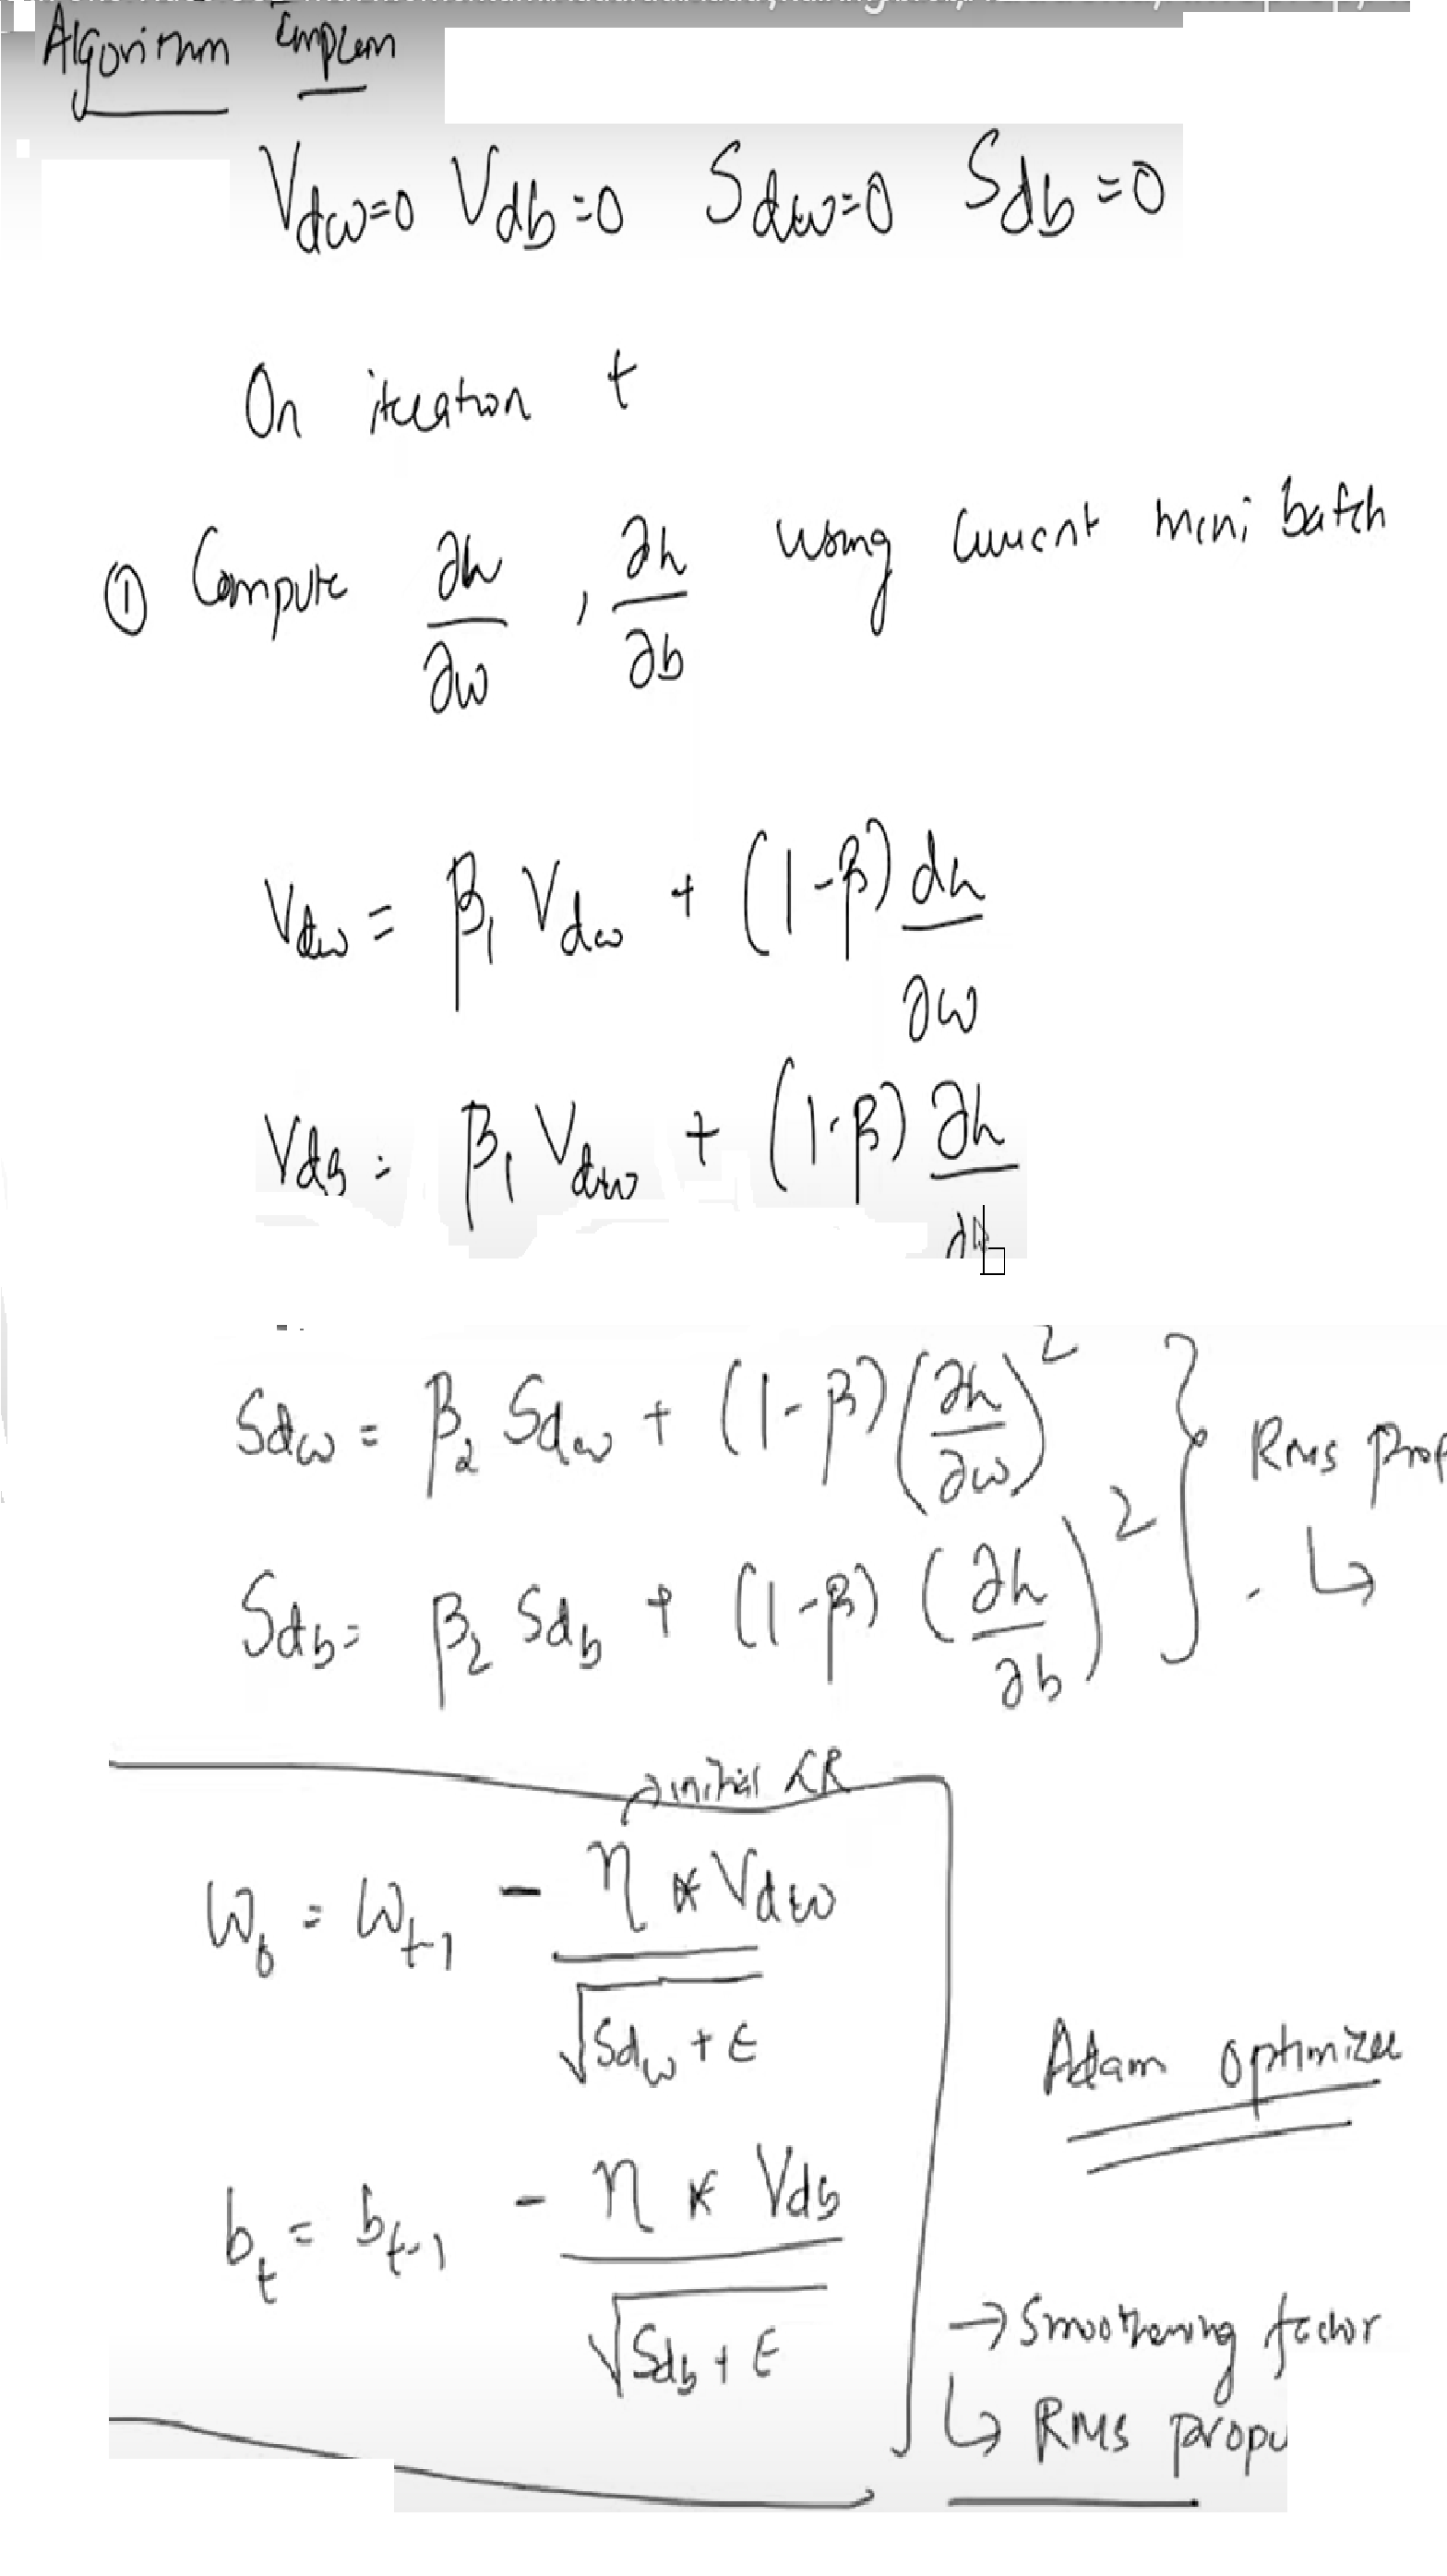

In [ ]:
class Linear():
    def __init__(self,input_dim,output_dim,B1=0.9,B2=0.99):
        self.Weight=np.random.randint(0,2,size=(input_dim,output_dim)).astype('float32')#*np.sqrt(6./input_dim+output_dim)#Xavier Initializatio
        #the weight of momentum and rmsprom are qeual to the weighs
        self.Vdw=np.zeros((input_dim,output_dim))
        self.Sdw=np.zeros((input_dim,output_dim))
        self.B1=B1
        self.B2=B2
        self.eps=0.0001
        #self.Weight=np.random.uniform(-1,1,size=(input_dim,output_dim))*np.sqrt(6./input_dim+output_dim)#Xavier Initializatio
    def forward(self,data):# data shape is batchsize,....,hidden layer
        self.input=data
        output=np.dot(data,self.Weight)
        return output
    
    def update(self,lr):
        
        self.Weight=self.Weight-(lr*self.Vdw)/(np.sqrt)
        
        
    def backward(self,err,lr):
        der_W=np.dot((self.input).reshape(-1,self.input.shape[-1]).T,err.reshape(-1,err.shape[-1])).astype('float32') 
        der_inp=np.dot(err,self.Weight.T)
        
        self.Vdw=self.B1*(self.Vdw)+(1-self.B1)*der_W
        self.Sdw=self.B2*(self.Sdw)+(1-self.B2)*(der_W**2+self.eps)# a small constant is added when derivative becomes zero numerator becomes infinits and loss becomes nan
        
        self.update(lr)
        return der_inp


NameError: name 'net' is not defined